In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thesis.functions.LSMC import average_lsmc, compute_mean_absolute_error
from thesis.analytical_dec_bdd import solve_decision_boundary

# Robustness analysis

## Global constants and regression setup

In [ ]:
S_0 = 100    # Initial stock price
r = 0.06    # Stock price risk-neutral mean
T = 1       # Maturity

reg_degree = 4
reg_poly = "laguerre"

model = 'gbm'

## Volatility

### Price analysis for a range of volatility levels

#### Calculate the prices approximations and their errors and save the results

In [ ]:
K = 110     # Strike price

# Set a range of volatilities under consideration
sigmas = [i/10 for i in range(1, 10)]
prices_analytical = [10.0000, 11.5889, 15.1743, 19.0230, 22.9237, 26.8175, 30.6770, 34.4853, 38.2296]
prices = []
errors = []

# Set hyperparameters to those found optimal for price approximation
N = 252     # Number of time steps
dt = T/N
M = 10000   # Number of sample paths
L = 10      # Number of simulations

for idx, sigma in enumerate(sigmas):
    constants = [S_0, r, sigma]
    # Compute and store the price using the average_lsmc function
    ave_price, ave_decision_boundary = average_lsmc(L, model, constants, K, M, N, dt, reg_degree, reg_poly)
    prices.append(ave_price)

    # Compute and store the error in the price approximation against the analytical solution
    error = ave_price - prices_analytical[idx]
    errors.append(error)

# Save the results to txt file
with open("../results/robustness/results_vary_vol.txt", "w") as f:
    f.write(f"sigmas = {sigmas}\n")
    f.write(f"prices_analytical = {prices_analytical}\n")
    f.write(f"prices = {prices}\n")
    f.write(f"errors = {errors}\n")
    

#### Plot the analytical prices, the LSMC approximations and their errors

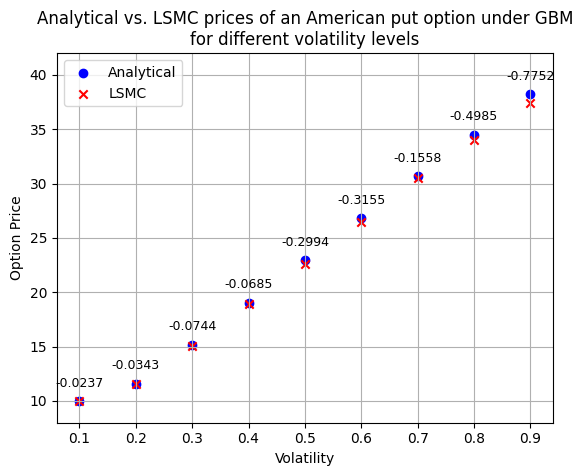

In [84]:
# Make a scatterplot of the analytical price and the approximations
plt.scatter(sigmas, prices_analytical, label='Analytical', color='blue', marker='o')
plt.scatter(sigmas, prices, label='LSMC', color='red', marker='x')
# Annotate with the error values
for x, t, a, e in zip(sigmas, prices_analytical, prices, errors):
    y_annot = max(t, a) + 1.05  # above the higher value
    plt.text(x, y_annot, f"{e:.4f}", ha='center', va='bottom', fontsize=9, color='black')

# Design and save the plot
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.ylim(8, 42)
plt.title('Analytical vs. LSMC prices of an American put option under GBM' + '\n' +
          'for different volatility levels')
plt.legend()
plt.grid(True)
plt.savefig("../results/plots/prices_vary_vol.png", bbox_inches='tight')
plt.show()

#### Calculate and plot relative errors

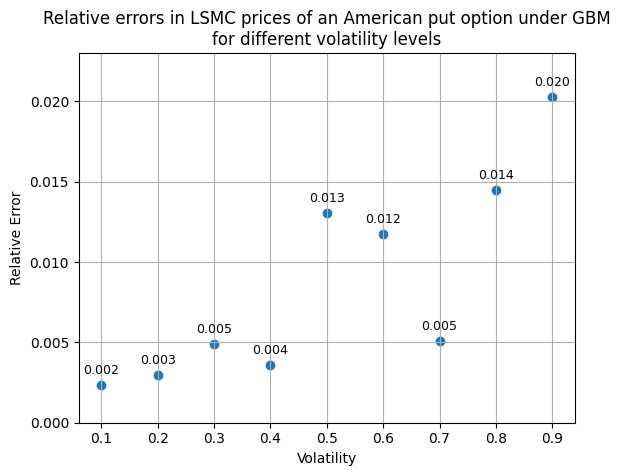

In [86]:
relative_errors = [abs(errors[i])/prices_analytical[i] for i in range(9)]

plt.scatter(sigmas, relative_errors)
for x, e in zip(sigmas, relative_errors):
    y_annot = e + 0.0005  # above the higher value
    plt.text(x, y_annot, f"{e:.3f}", ha='center', va='bottom', fontsize=9, color='black')

# Design and save the plot
plt.xlabel('Volatility')
plt.ylabel('Relative Error')
plt.ylim(0, 0.023)
plt.title('Relative errors in LSMC prices of an American put option under GBM' + '\n' +
          'for different volatility levels')
plt.grid(True)
plt.savefig("../results/plots/relative_errors_vary_vol.png", bbox_inches='tight')
plt.show()

### Decision boundary analysis for high volatility

#### Calculate the decision boundary approximation and save the result

In [ ]:
K = 110         # Strike price

# Set a high volatility constant
sigma = 0.8     
constants = [S_0, r, sigma]

# Set hyperparameters to those found optimal for decision boundary approximation
N = 50      # Number of time steps
dt = T/N
time_grid = np.linspace(dt, T, N)
M = 1000000  # Number of sample paths
L = 100      # Number of simulations

# Find and save the analytical decision boundary solution
grid, analytical_decision_boundary_high_vol = solve_decision_boundary(K, r, sigma, T, n=1000)
np.save("../results/robustness/analytical_decision_boundary_high_vol.npy", analytical_decision_boundary_high_vol[::-1])

# Compute the decision boundary approximation using the average_lsmc function and save the result
ave_price_high_vol, ave_decision_boundary_high_vol = average_lsmc(L, model, constants, K, M, N, dt, reg_degree, reg_poly)
np.save(f"../results/robustness/decision_boundary_high_vol.npy", ave_decision_boundary_high_vol)


#### Plot the high volatility decision boundary result in comparison to standard volatility

The Mean Absolute Error with high vol is 4.311808615025027


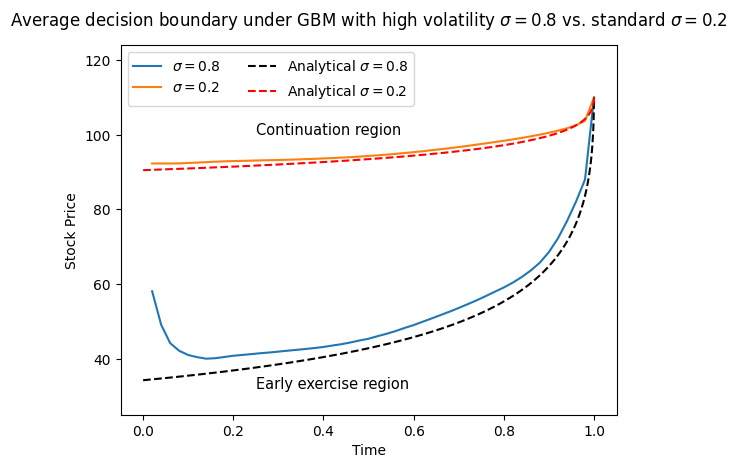

In [78]:
# Load the results
decision_boundary_high_vol = np.load("../results/robustness/decision_boundary_high_vol.npy")
decision_boundary_standard_vol = np.load("../results/GBM/decision_boundary_M=1000000_N=50.npy")
analytical_decision_boundary_high_vol = np.load("../results/robustness/analytical_decision_boundary_high_vol.npy")
analytical_decision_boundary_standard_vol = np.load("../results/GBM/analytical_decision_boundary_1000.npy")

# Compute the MAE of the high vol decision boundary approximation against the analytical solution
L1_loss = compute_mean_absolute_error(analytical_decision_boundary_high_vol, decision_boundary_high_vol)
print("The Mean Absolute Error with high vol is", L1_loss)

N = 50      # Number of time steps
dt = T/N
time_grid = np.linspace(dt, T, N)

min_boundary = min(decision_boundary_high_vol)

# Plot all the results
plt.plot(time_grid, decision_boundary_high_vol, label=r'$\sigma = 0.8$')
plt.plot(time_grid, decision_boundary_standard_vol, label=r'$\sigma = 0.2$')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_high_vol, color='black', linestyle='--',label=r'Analytical $\sigma = 0.8$')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_standard_vol, color='red', linestyle='--',label=r'Analytical $\sigma = 0.2$')

# Design and save the graph
plt.legend(ncol=2, loc='upper left', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title(r'Average decision boundary under GBM with high volatility $\sigma = 0.8$ vs. standard $\sigma = 0.2$', y=1.03)
plt.text(T/4, min_boundary-8, "Early exercise region", fontsize=10.5)
plt.text(T/4, 100, "Continuation region", fontsize=10.5)
plt.ylim(min_boundary-15, 124)
plt.savefig("../results/plots/decision_boundary_high_vol.png", bbox_inches='tight')
plt.show()

## Moneyness

### Price analysis for a range of moneyness levels

#### Calculate the prices approximations and their errors and save the results

In [ ]:
sigma = 0.2     # Constant volatility   
constants = [S_0, r, sigma]

# Set a range of moneyness levels under consideration
strikes = [90, 100, 110, 120] #OTM, ATM, ITM, deep ITM
prices_analytical_K = [2.3480, 5.8112, 11.5889, 20.0035]
prices_K = []
errors_K = []

# Set hyperparameters to those found optimal for price approximation
N = 252     # Number of time steps
dt = T/N
M = 10000   # Number of sample paths
L = 10      # Number of simulations

for idx, K in enumerate(strikes):  
    # Compute the price using the average_lsmc function and store it
    ave_price, ave_decision_boundary = average_lsmc(L, model, constants, K, M, N, dt, reg_degree, reg_poly)
    prices_K.append(ave_price)

    # Compute and store the error in the price approximation against the analytical solution
    error = ave_price - prices_analytical_K[idx]
    errors_K.append(error)

# Save the results to txt file
with open("../results/robustness/results_vary_strike.txt", "w") as f:
    f.write(f"strikes = {strikes}\n")
    f.write(f"prices_analytical_K = {prices_analytical_K}\n")
    f.write(f"prices_K = {prices_K}\n")
    f.write(f"errors_K = {errors_K}\n")
    

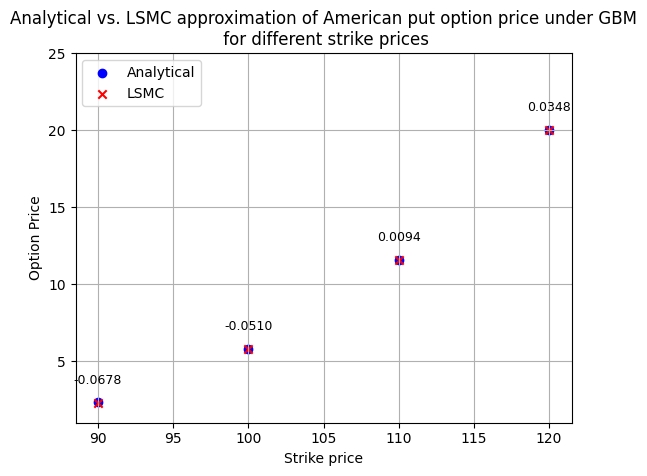

In [88]:
strikes = [90, 100, 110, 120]
prices_true_K = [2.3480, 5.8112, 11.5889, 20.0035]
prices_K = [2.280204938245306, 5.760211769687116, 11.598306967228936, 20.03832672747616]
errors_K = [prices_K[i]-prices_true_K[i] for i in range(4)]

plt.scatter(strikes, prices_true_K, label='Analytical', color='blue', marker='o')
plt.scatter(strikes, prices_K, label='LSMC', color='red', marker='x')
for x, t, a, e in zip(strikes, prices_true_K, prices_K, errors_K):
    plt.plot([x, x], [t, a], color='gray', linestyle='--', linewidth=1)
    y_annot = max(t, a) + 1  # above the higher value
    plt.text(x, y_annot, f"{e:.4f}", ha='center', va='bottom', fontsize=9, color='black')

# Labels and legend
plt.xlabel('Strike price')
plt.ylabel('Option Price')
plt.ylim(1,25)
plt.title('Analytical vs. LSMC approximation of American put option price under GBM' + '\n' +
          ' for different strike prices')
plt.legend()
plt.grid(True)
plt.savefig("../results/plots/prices_vary_strike.png", bbox_inches='tight')
plt.show()

#### Plot the numerical errors

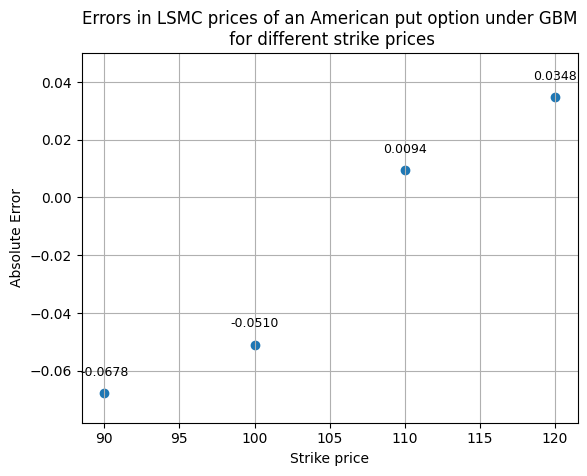

In [99]:
plt.scatter(strikes, errors_K)
for x, e in zip(strikes, errors_K):
    y_annot = e + 0.005  # above the value
    plt.text(x, y_annot, f"{e:.4f}", ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Strike price')
plt.ylabel('Absolute Error')
plt.ylim(-0.078,0.05)
plt.title('Errors in LSMC prices of an American put option under GBM' + '\n' +
          ' for different strike prices')
plt.grid(True)
plt.savefig("../results/plots/errors_vary_strike.png", bbox_inches='tight')
plt.show()

#### Plot absolute errors

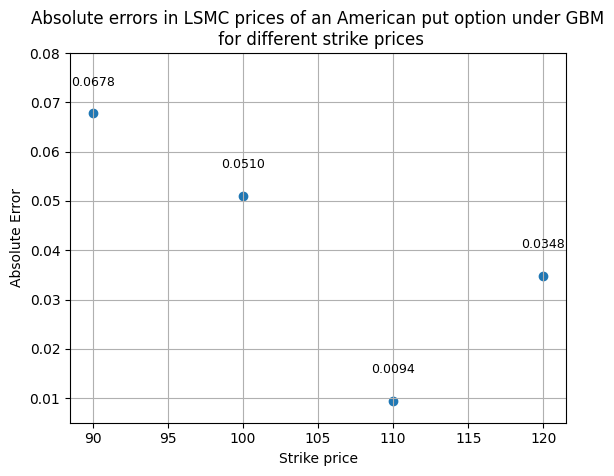

In [104]:
abs_errors_K = [abs(e) for e in errors_K]

plt.scatter(strikes, abs_errors_K)
for x, e in zip(strikes, abs_errors_K):
    y_annot = e + 0.005  # above the value
    plt.text(x, y_annot, f"{e:.4f}", ha='center', va='bottom', fontsize=9, color='black')

# Labels and legend
plt.xlabel('Strike price')
plt.ylabel('Absolute Error')
plt.ylim(0.005,0.08)
plt.title('Absolute errors in LSMC prices of an American put option under GBM' + '\n' +
          ' for different strike prices')
plt.grid(True)
plt.show()

#### Calculate and plot the relative errors

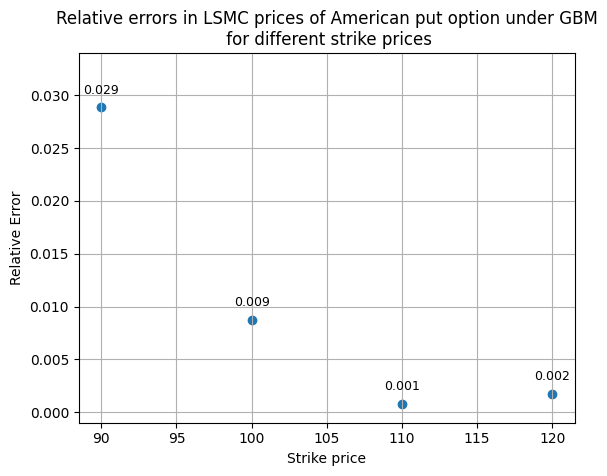

In [103]:
relative_errors_K = [abs_errors_K[i]/prices_true_K[i] for i in range(4)]

plt.scatter(strikes, relative_errors_K)
for x, e in zip(strikes, relative_errors_K):
    y_annot = e + 0.001  # above the value
    plt.text(x, y_annot, f"{e:.3f}", ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Strike price')
plt.ylabel('Relative Error')
plt.ylim(-0.001,0.034)
plt.title('Relative errors in LSMC prices of American put option under GBM' + '\n' +
          ' for different strike prices')
plt.grid(True)
plt.savefig("../results/plots/relative_errors_vary_strike.png", bbox_inches='tight')
plt.show()

### Decision boundary analysis for OTM option

#### Calculate the decision boundary approximation and save the result

In [32]:
sigma = 0.2
constants = [S_0, r, sigma]

# Set a strike price for OTM option
K = 90

# Set hyperparameters to those found optimal for decision boundary approximation
N = 50      # Number of time steps
dt = T/N
time_grid = np.linspace(dt, T, N)
M = 1000000  # Number of sample paths
L = 100      # Number of simulations

# Find and save the analytical decision boundary solution
grid, analytical_decision_boundary_OTM = solve_decision_boundary(K, r, sigma, T, n=1000)
np.save("../results/robustness/analytical_decision_boundary_OTM.npy", analytical_decision_boundary_OTM[::-1])

# Compute the decision boundary approximation using the average_lsmc function and save the result
ave_price_OTM, ave_decision_boundary_OTM = average_lsmc(L, model, constants, K, M, N, dt, reg_degree, reg_poly)
np.save(f"../results/robustness/decision_boundary_OTM.npy", ave_decision_boundary_OTM)

100%|██████████| 100/100 [7:49:25<00:00, 281.65s/it] 


#### Plot the OTM decision boundary result in comparison to ITM

2.1680683206076115
The Mean Absolute Error for OTM option is 1.5894449285199816


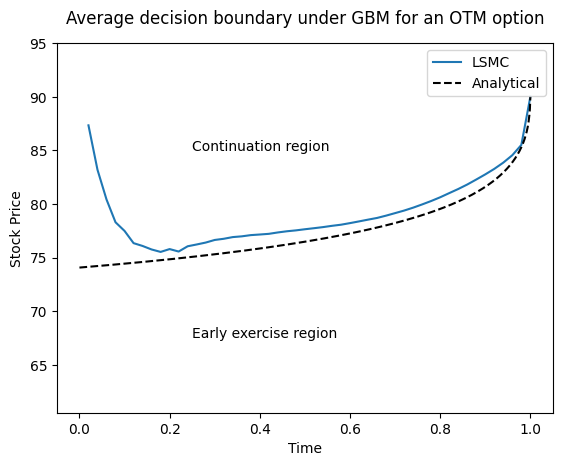

In [34]:
# Load all the results
decision_boundary_OTM = np.load("../results/robustness/decision_boundary_OTM.npy")
decision_boundary_ITM = np.load("../results/GBM/decision_boundary_M=1000000_N=50.npy")
analytical_decision_boundary_OTM = np.load("../results/robustness/analytical_decision_boundary_OTM.npy")
analytical_decision_boundary_ITM = np.load("../results/GBM/analytical_decision_boundary_1000.npy")

# Compute the MAE of the OTM decision boundary approximation against the analytical solution
L1_loss_OTM = compute_mean_absolute_error(analytical_decision_boundary_OTM, ave_decision_boundary_OTM)
print("The Mean Absolute Error for OTM option is", L1_loss_OTM)

min_boundary = min(ave_decision_boundary_OTM)

N = 50      # Number of time steps
dt = T/N
time_grid = np.linspace(dt, T, N)

# Plot the results
plt.plot(time_grid, decision_boundary_OTM, label='OTM')
plt.plot(time_grid, decision_boundary_ITM, label='ITM')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_OTM, color='black', linestyle='--',label='Analytical OTM')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_ITM, color='red', linestyle='--',label='Analytical ITM')

# Design and save the graph
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title(r'Average decision boundary under GBM for an OTM vs. ITM option', y=1.03)
plt.text(T/4, min_boundary-8, "Early exercise region")
plt.text(T/4, 100, "Continuation region")
plt.ylim(min_boundary-8, 121)
plt.savefig("../results/plots/decision_boundary_OTM.png", bbox_inches='tight')
plt.show()

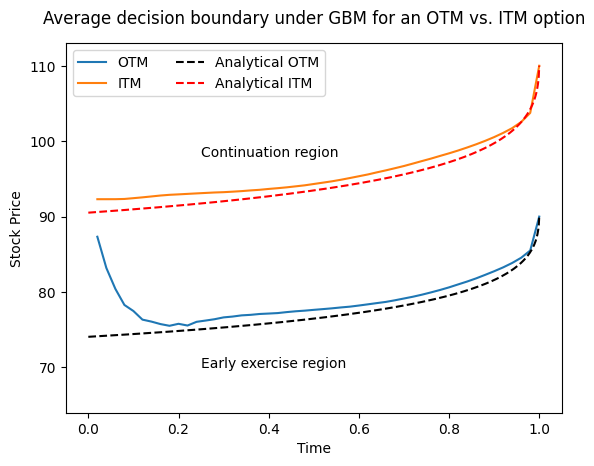

In [8]:
# Load all the results
decision_boundary_OTM = np.load("../results/robustness/decision_boundary_OTM.npy")
decision_boundary_ITM = np.load("../results/GBM/decision_boundary_M=1000000_N=50.npy")
analytical_decision_boundary_OTM = np.load("../results/robustness/analytical_decision_boundary_OTM.npy")
analytical_decision_boundary_ITM = np.load("../results/GBM/analytical_decision_boundary_1000.npy")

# Compute the MAE of the OTM decision boundary approximation against the analytical solution
L1_loss_OTM = compute_mean_absolute_error(analytical_decision_boundary_OTM, ave_decision_boundary_OTM)
print("The Mean Absolute Error for OTM option is", L1_loss_OTM)

N = 50      # Number of time steps
dt = T/N
time_grid = np.linspace(dt, T, N)

# Plot the results
plt.plot(time_grid, decision_boundary_OTM, label='OTM')
plt.plot(time_grid, decision_boundary_ITM, label='ITM')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_OTM, color='black', linestyle='--',label='Analytical OTM')
plt.plot(np.linspace(0, T, 1001), analytical_decision_boundary_ITM, color='red', linestyle='--',label='Analytical ITM')

# Design and save the graph
plt.legend(ncol=2, loc='upper left')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title(r'Average decision boundary under GBM for an OTM vs. ITM option', y=1.03)
plt.text(T/4, 70, "Early exercise region")
plt.text(T/4, 98, "Continuation region")
plt.ylim(64, 113)
plt.savefig("../results/plots/decision_boundary_OTM_compare.png", bbox_inches='tight')
plt.show()